In [1]:
# Import necessary libraries



import numpy as np



import os



import torch



import time



import pymust # Assuming pymust is installed and contains dasmtx3



from vectorized_beamformer3D import vectorized_beamform



import matplotlib.pyplot as plt



from pymust import utils

In [2]:
# Load simulated data



data_dir = "simulated_data"



try:



    print(f"Loading data from '{data_dir}'...")



    xi = np.load(os.path.join(data_dir, 'xi.npy'))



    yi = np.load(os.path.join(data_dir, 'yi.npy'))



    zi = np.load(os.path.join(data_dir, 'zi.npy'))



    txdel3 = np.load(os.path.join(data_dir, 'txdel3.npy'))



    param_data = np.load(os.path.join(data_dir, 'param_data.npy'), allow_pickle=True).item()



    RF3 = np.load(os.path.join(data_dir, 'RF3.npy'))



    print("Data loaded successfully.")







    # Create utils.Param object from loaded data



    param = utils.Param()



    param.update(param_data)







    # Demodulate RF data



    print("Demodulating RF data...")



    IQ3 = pymust.rf2iq(RF3, param.fs, param.fc) # Use param object for fs and fc



    print(f"I/Q data generated. Shape: {IQ3.shape}")







except FileNotFoundError:



    print(f"Error: Data files not found in '{data_dir}'. Please run simulate_data.py first.")



except ImportError:



    print("Error: Required libraries (numpy, torch, pymust, matplotlib) not found. Please install them.")



except Exception as e:



    print(f"An error occurred during data loading or demodulation: {e}")

Loading data from 'simulated_data'...
Data loaded successfully.
Demodulating RF data...
I/Q data generated. Shape: (560, 1024)


In [3]:
# --- Beamforming and Timing ---







# 1. PyMUST dasmtx3 Beamforming



print("\nRunning PyMUST dasmtx3 beamforming...")



start_time_pymust = time.perf_counter()



M3 = pymust.dasmtx3(IQ3, xi, yi, zi, txdel3, param) # Get sparse matrix



bIQ3_pymust = pymust.utils.applyDasMTX(M3, IQ3, xi.shape) # Apply matrix and get dense array



end_time_pymust = time.perf_counter()



time_pymust = end_time_pymust - start_time_pymust



print(f"PyMUST beamforming complete. Shape: {bIQ3_pymust.shape}")



print(f"PyMUST time: {time_pymust:.4f} seconds")







# 2. CPU PyTorch Beamforming



print("\nRunning CPU PyTorch beamforming...")



start_time_cpu = time.perf_counter()



bIQ3_cpu = vectorized_beamform(IQ3, xi, yi, zi, txdel3, param, device='cpu') # Pass param object



end_time_cpu = time.perf_counter()



time_cpu = end_time_cpu - start_time_cpu



print(f"CPU PyTorch beamforming complete. Shape: {bIQ3_cpu.shape}"),



print(f"CPU PyTorch time: {time_cpu:.4f} seconds")







# 3. GPU PyTorch Beamforming



bIQ3_gpu = None



time_gpu = None



if torch.cuda.is_available():



    print("\nRunning GPU PyTorch beamforming...")



    start_event = torch.cuda.Event(enable_timing=True)



    end_event = torch.cuda.Event(enable_timing=True)







    # Warm-up run



    _ = vectorized_beamform(IQ3, xi, yi, zi, txdel3, param, device='cuda') # Pass param object



    torch.cuda.synchronize() # Ensure warm-up is complete







    start_event.record()



    bIQ3_gpu = vectorized_beamform(IQ3, xi, yi, zi, txdel3, param, device='cuda') # Pass param object



    end_event.record()







    torch.cuda.synchronize() # Wait for all GPU ops and CPU transfer



    time_gpu = start_event.elapsed_time(end_event) / 1000.0 # Convert to seconds



    print(f"GPU PyTorch beamforming complete. Shape: {bIQ3_gpu.shape}"),



    print(f"GPU PyTorch time: {time_gpu:.4f} seconds")



else:



    print("CUDA not available. Skipping GPU PyTorch beamforming.")


Running PyMUST dasmtx3 beamforming...
PyMUST beamforming complete. Shape: (64, 64, 128)
PyMUST time: 99.6396 seconds

Running CPU PyTorch beamforming...
Starting vectorized beamforming (PyTorch implementation) on device: cpu with single precision...
Processing grid in chunks of size 4 along Z-axis...
Processing grid in chunks of size (64, 64) along X and Y axes within each Z chunk...
CPU PyTorch beamforming complete. Shape: (1, 64, 64, 128)
CPU PyTorch time: 29.8782 seconds

Running GPU PyTorch beamforming...
Starting vectorized beamforming (PyTorch implementation) on device: cuda with single precision...
Processing grid in chunks of size 4 along Z-axis...
Processing grid in chunks of size (64, 64) along X and Y axes within each Z chunk...
Starting vectorized beamforming (PyTorch implementation) on device: cuda with single precision...
Processing grid in chunks of size 4 along Z-axis...
Processing grid in chunks of size (64, 64) along X and Y axes within each Z chunk...
GPU PyTorch be

In [4]:
# --- Display Times ---



print("\n--- Beamformer Execution Times ---")



print(f"PyMUST time: {time_pymust:.4f} seconds")



print(f"CPU PyTorch time: {time_cpu:.4f} seconds")



if time_gpu is not None:



    print(f"GPU PyTorch time: {time_gpu:.4f} seconds")



    if time_cpu is not None and time_cpu > 0:



        speedup_gpu_vs_cpu = time_cpu / time_gpu



        print(f"GPU vs CPU Speedup: {speedup_gpu_vs_cpu:.2f}x")


--- Beamformer Execution Times ---
PyMUST time: 99.6396 seconds
CPU PyTorch time: 29.8782 seconds
GPU PyTorch time: 1.2372 seconds
GPU vs CPU Speedup: 24.15x



--- Generating 2D Plots of Center Slice ---


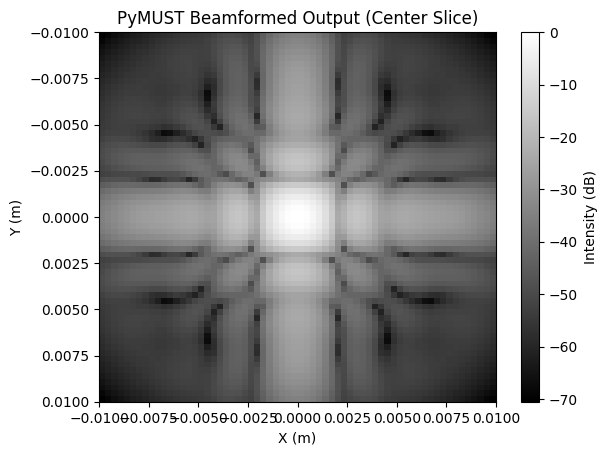

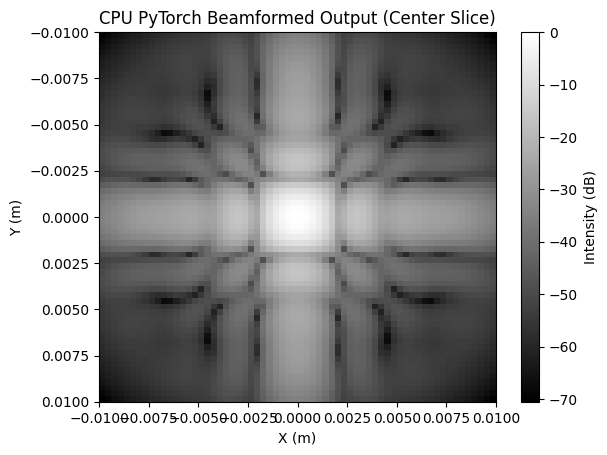

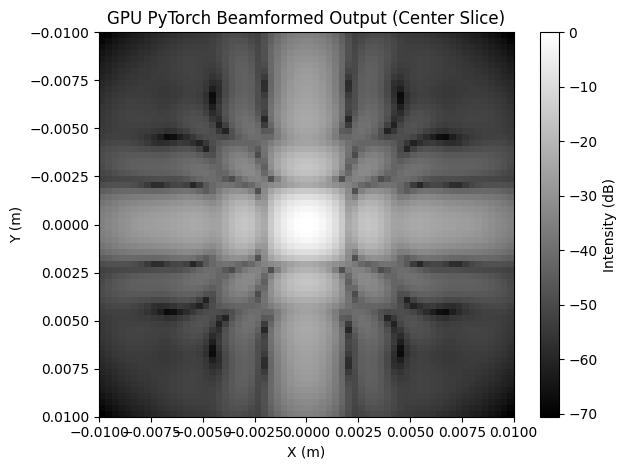

--- Plotting Complete ---


In [6]:
# --- 2D Plotting of Center Slice ---







print("\n--- Generating 2D Plots of Center Slice ---")







def plot_center_slice(data, xi, yi, zi, title):



    if data is None:



        print(f"Skipping plot for '{title}' as data is not available.")



        return None







    # Find the index of the center slice in the z-dimension



    center_z_index = zi.shape[2] // 2







    # Extract the center slice



    slice_data = data[:, :, center_z_index]



    slice_xi = xi[:, :, center_z_index]



    slice_yi = yi[:, :, center_z_index]







    # Calculate intensity in dB



    abs_data = np.abs(slice_data)



    abs_data[abs_data == 0] = np.finfo(float).eps # Avoid log10(0)



    db_data = 20 * np.log10(abs_data / np.max(abs_data))







    # Create plot



    fig, ax = plt.subplots()



    # Use extent to set the axis limits based on spatial coordinates



    im = ax.imshow(db_data, extent=[slice_xi.min(), slice_xi.max(), slice_yi.max(), slice_yi.min()], aspect='auto', cmap='gray')



    ax.set_title(title)



    ax.set_xlabel('X (m)')



    ax.set_ylabel('Y (m)')



    plt.colorbar(im, label='Intensity (dB)')



    return fig







# Plot the center slice for each beamformer's output



fig_pymust = plot_center_slice(bIQ3_pymust, xi, yi, zi, 'PyMUST Beamformed Output (Center Slice)')



fig_cpu = plot_center_slice(bIQ3_cpu[0, :, :, :], xi, yi, zi, 'CPU PyTorch Beamformed Output (Center Slice)')



fig_gpu = plot_center_slice(bIQ3_gpu[0, :, :, :], xi, yi, zi, 'GPU PyTorch Beamformed Output (Center Slice)')







plt.tight_layout()



plt.show()







print("--- Plotting Complete ---")